In this tutorial we introduce the DoG-HiT script as it is adapted in practice and discuss some more advanced options. Let us first load the modules and the data as usual.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np

from imagingbase.ehtim_calibration import Calibrator
from imagingbase.minimization_handler import MinimizationHandler

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

Welcome to eht-imaging! v 1.2.6 



In [2]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 0.6                 # Total compact flux density (Jy)
npix      = 32                 # Number of pixels across the reconstructed image
fov       = 2*128*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities
                                                               
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-4                # Imager stopping criterion
gain_tol  = [0.02,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['AA', 'AP']    # baseline to measure zero-spacing flux
rescaling = 0.0001              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 8*10**9]       #cbar-lims for interactive plotting (brightness temperature)

Loading uvfits:  /homes/hmueller/mrbeam/mr_beam/examples/../synthetic_data/ring_eht2017.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  /homes/hmueller/mrbeam/mr_beam/examples/../synthetic_data/ring.fits


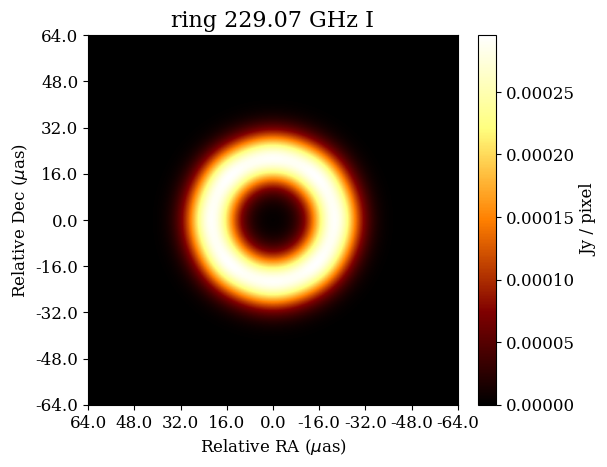

In [3]:
#-------------------------------------------------------------------------------
# Observe synthetic image and reduce/precalibrate synthetic observation
#-------------------------------------------------------------------------------

obs = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/ring_eht2017.uvfits')

#calibration object
cal = Calibrator(obs, zero_baseline, zbl, uv_zblcut, 0, sys_noise)
#prepare (coherently average) data
cal.prepare_data()
#precalibrate data
cal.precalibrate_data()

obs_sc = cal.obs_sc #precalibrated and reduced data set
obs_sc_init = obs_sc.copy()

exact_solution = eh.image.load_fits(current_path+r'/../synthetic_data/ring.fits')

exact_solution.display()

res = obs_sc.res()

In [4]:
prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
prior = prior.add_gauss(1e-2*zbl, (prior_fwhm, prior_fwhm, 0, prior_fwhm, prior_fwhm))

What is the ideal wavelet dictionary to separate between features that are covered by observations and those that are not covered by observations? In Fourier domain this would be difference Bessel functions, in image domain we have seen that difference of Gaussian functions work best. Therefore, we adapt two different dictionaries in the following. We first fit the data with a dictionary that fits optimally to the uv-coverage, but contains many sidelobes, and then change to a dictionary with consisting out of Gaussians. For more details on this approach we refer to our discussion of DoB-CLEAN and Mueller,Lobanov 2023a. This changing can be achieved by the command: "handler.change_dictionary()"

Moreover, dictionaries should be directional dependent since the uv-coverage typically has a directional dependence. This is achieved by the usage of difference of elliptical Gaussian/Bessel functions, for more details we refer to Mueller, Lobanov 2023a. 

Let us first construct the handler. We identify with md=True that we want to use elliptical functions (with ellipticities the number of different angles per radial scale), and with bessels=True, that we want to use the two-dictionaries technique. 

In [5]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#clean beam fwhm
psf_fwhm = res

#threshold for identifying gaps in uv-coverage
threshold = 3*10**8
#add short baselines wavelets 
short_bl_wl=[]
#add long baseline wavelets
long_bl_wl=[]
#fraction of fov to use for wavelets: ~0.5-1
ffov = 0.4
#find widths by wrapper method, arguments of 
from imagingbase.ehtim_wrapper import EhtimWrapper
wrapper = EhtimWrapper(obs_sc.copy(), prior.regrid_image(fov, npix+1), prior.regrid_image(fov, npix+1), zbl, debias=False)
widths = wrapper.find_widths(threshold, ffov)

#the final handler for the minimization procedure
handler = MinimizationHandler(psf_fwhm, npix, fov, obs_sc, prior, zbl, rescaling, data_term, cbar_lims, threshold, short_bl_wl, long_bl_wl, md=True, bessel=True, ellipticities=4, widths=widths) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...
Generating I image...
Generating I image...


Next we would find a reasonable initial guess, self-calibrate, construct a mulitscalar and multidirectional coeeficient array, grid-search for the best solution, change the dictionary, run the DoG-HiT forward-backward splitting and find the multiresolution support. There is a shortcut for all these steps.

Round 1: Find initial guess ...
Initializing imager data products . . .
U-V flagged 16/168 visibilities
U-V flagged 152/168 visibilities
Imager run 1 
Imaging . . .
time: 0.391462 s
J: 17.661753
chi2_amp : 39.90 chi2_cphase : 5.31 chi2_logcamp : 6.34 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 0.308516 s
J: 0.753001
chi2_amp : 3.72 chi2_cphase : 1.54 chi2_logcamp : 0.65 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 0.304205 s
J: -0.123457
chi2_amp : 1.52 chi2_cphase : 1.26 chi2_logcamp : 0.51 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
Imaging . . .
time: 0.379153 s
J: -0.499941
chi2_amp : 0.98 chi2_cphase : 1.01 chi2_logcamp : 0.49 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 5 
Imaging . . .
time: 0.314733 s
J: -0.774651
chi2_amp : 0.83 chi2_cphase : 0.79 chi2_logcamp : 0.47 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 6 
Imaging . . .
time: 0.309695 s
J: -0.856443
chi2_amp : 0.77

2023-10-18 15:51:41,433 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:51:41,434 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:41,617 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:51:41,618 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:41,801 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:51:41,802 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:41,985 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:51:41,987 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:42,169 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:51:42,171 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:42,354 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:51:42,355 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:42,539 INFO CountIterations      :: iteration = 7 / 2

5478.016453915965
Data Fidelity:  25.88295935462949


2023-10-18 15:51:46,142 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:51:46,143 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:46,326 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:51:46,327 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:46,510 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:51:46,511 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:46,694 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:51:46,695 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:46,879 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:51:46,880 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:47,063 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:51:47,064 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:47,247 INFO CountIterations      :: iteration = 7 / 2

5999.719906514884
Data Fidelity:  25.866286713772027


2023-10-18 15:51:50,877 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:51:50,879 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:51,061 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:51:51,062 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:51,245 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:51:51,246 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:51,430 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:51:51,431 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:51,614 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:51:51,615 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:51,798 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:51:51,799 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:51,982 INFO CountIterations      :: iteration = 7 / 2

5999.719955749908
Data Fidelity:  25.849640555135462


2023-10-18 15:51:55,583 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:51:55,584 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:55,767 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:51:55,768 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:55,952 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:51:55,953 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:56,135 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:51:56,137 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:56,320 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:51:56,321 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:56,503 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:51:56,505 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:51:56,687 INFO CountIterations      :: iteration = 7 / 2

5999.720005004224
Data Fidelity:  25.83302078816414


2023-10-18 15:52:00,310 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:52:00,311 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:00,494 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:52:00,495 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:00,677 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:52:00,679 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:00,861 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:52:00,863 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:01,041 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:52:01,043 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:01,228 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:52:01,230 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:01,415 INFO CountIterations      :: iteration = 7 / 2

5999.720054277692
Data Fidelity:  25.816427322761765


2023-10-18 15:52:05,026 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:52:05,027 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:05,209 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:52:05,211 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:05,394 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:52:05,395 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:05,579 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:52:05,581 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:05,765 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:52:05,766 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:05,950 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:52:05,952 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:06,133 INFO CountIterations      :: iteration = 7 / 2

5999.720103570167
Data Fidelity:  25.79986006928943


2023-10-18 15:52:09,755 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:52:09,757 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:09,939 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:52:09,941 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:10,116 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:52:10,117 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:10,301 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:52:10,303 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:10,484 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:52:10,486 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:10,669 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:52:10,670 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:10,852 INFO CountIterations      :: iteration = 7 / 2

5999.720152881502
Data Fidelity:  25.783318938563752


2023-10-18 15:52:14,437 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:52:14,438 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:14,623 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:52:14,624 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:14,809 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:52:14,810 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:14,994 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:52:14,995 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:15,177 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:52:15,179 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:15,362 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:52:15,364 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:15,547 INFO CountIterations      :: iteration = 7 / 2

5999.72020221155
Data Fidelity:  25.766803841854813


2023-10-18 15:52:19,178 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:52:19,179 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:19,363 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:52:19,364 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:19,547 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:52:19,548 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:19,731 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:52:19,733 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:19,917 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:52:19,918 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:20,101 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:52:20,103 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:20,286 INFO CountIterations      :: iteration = 7 / 2

5999.720251560161
Data Fidelity:  25.750314690884174


2023-10-18 15:52:23,865 INFO CountIterations      :: iteration = 1 / 25
2023-10-18 15:52:23,866 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:24,048 INFO CountIterations      :: iteration = 2 / 25
2023-10-18 15:52:24,049 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:24,232 INFO CountIterations      :: iteration = 3 / 25
2023-10-18 15:52:24,233 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:24,416 INFO CountIterations      :: iteration = 4 / 25
2023-10-18 15:52:24,417 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:24,599 INFO CountIterations      :: iteration = 5 / 25
2023-10-18 15:52:24,601 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:24,783 INFO CountIterations      :: iteration = 6 / 25
2023-10-18 15:52:24,785 INFO Display              :: Penalty--> 130.05628796744818
2023-10-18 15:52:24,967 INFO CountIterations      :: iteration = 7 / 2

5999.720300927194
Data Fidelity:  25.733851397822882


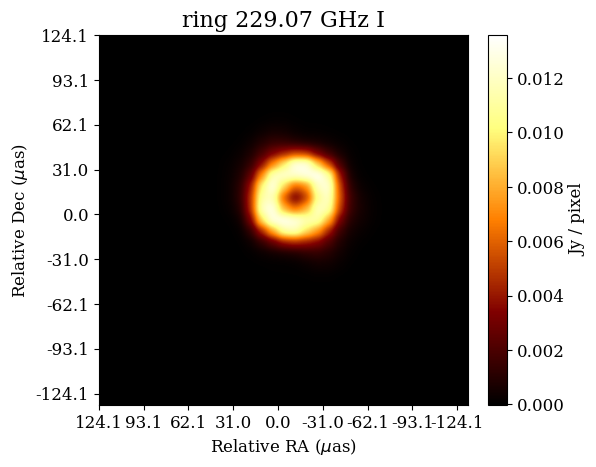

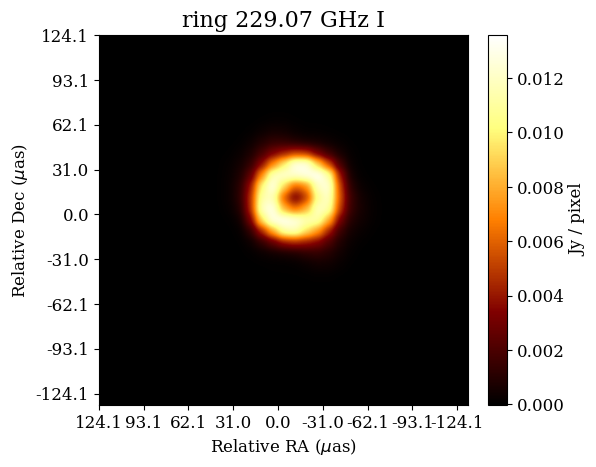

In [6]:
#------------------------------------------------------------------------------
# Run DoG-HiT
#------------------------------------------------------------------------------
alpha=0.1 #wavelet sparsity constraint
tau=1 #stepsize in minimization
img2, wtfcts2, table1, obs_sc = handler.doghit(prior, data_term, cycles=5, last_epochs=True, solution_interval=600, alpha=alpha, tau=tau, maxiter=10, display=False)
img2.display()

Since we are doing the imaging from the closure quantities, the reconstruction is independent against rescaling the reconstruction with a constant factor. Now, we calibrate the total flux. For this, we fix the relative structure, rescale the field with various constants and compute the chi-squared fit to the (uncalibrated) amplitudes. This is handled by the following command.

In [7]:
img2, wtfcts2, table2, obs_sc = handler.calibrate_full(obs_sc, obs_sc_init, img2, wtfcts2, uv_zblcut=uv_zblcut)

U-V flagged 152/168 visibilities
Generating I image...
Warning! Specified flux is > 120% of maximum visibility amplitude!
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 0.997937 s
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 1.008566 s


Now we add the usual refining steps

Third Round: Multiscalar Imaging with visibility amplitudes and closure quantities ...


2023-10-18 15:56:49,600 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 15:56:49,704 INFO Display              :: Data Fidelity--> 32.990084209287225
2023-10-18 15:56:49,981 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 15:56:50,085 INFO Display              :: Data Fidelity--> 32.95699212720124
2023-10-18 15:56:50,363 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 15:56:50,467 INFO Display              :: Data Fidelity--> 32.923984758705814
2023-10-18 15:56:50,745 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 15:56:50,850 INFO Display              :: Data Fidelity--> 32.89106170731243
2023-10-18 15:56:51,129 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 15:56:51,130 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 15:56:51,130 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 15:56:51,548 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 15:56:51,652 INFO Display   

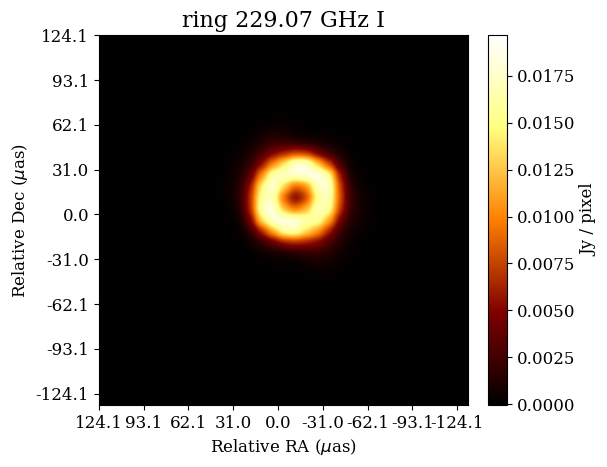

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 1.013155 s
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 1.029219 s


In [8]:
#-------------------------
# Third Round of Imaging: amplitude+closure-quantities + multiresolution support constraint
#-------------------------

print("Third Round: Multiscalar Imaging with visibility amplitudes and closure quantities ...")

#We add amplitudes to the constrained minimization
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

#run gradient descent minimization
#stepsize automatically found
wtfcts3, img3, tau = handler.third_round(wtfcts2, data_term, tau=tau, maxit=100)

img3.display()

#phase-calibration
table3 = eh.selfcal(obs_sc, img3, method='both', ttype=ttype, solution_interval=3600, caltable=True)
obs_sc = eh.selfcal(obs_sc, img3, method='both', ttype=ttype, solution_interval=3600)
handler.updateobs(obs_sc.copy())

Round 4: Multiscalar Imaging with visibilities and closure quantities ...


2023-10-18 16:03:24,752 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 16:03:24,856 INFO Display              :: Data Fidelity--> 40.3955363327983
2023-10-18 16:03:25,136 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 16:03:25,241 INFO Display              :: Data Fidelity--> 40.33837990743918
2023-10-18 16:03:25,520 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 16:03:25,596 INFO Display              :: Data Fidelity--> 40.28146776769909
2023-10-18 16:03:25,869 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 16:03:25,975 INFO Display              :: Data Fidelity--> 40.22479789064383
2023-10-18 16:03:26,253 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 16:03:26,254 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 16:03:26,254 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 16:03:26,683 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 16:03:26,787 INFO Display      

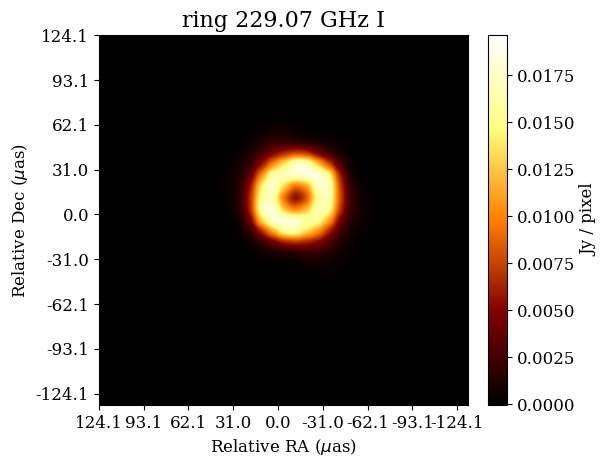

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 1.021248 s
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 8/9 : [--------------------------    ]88%
self_cal time: 1.006344 s


In [10]:
#-------------------------
# Fourth Round of Imaging: visibilities+closure_quantities + multiresolution support contraint
#-------------------------

print("Round 4: Multiscalar Imaging with visibilities and closure quantities ...")

#data weights
data_term = {'vis'    : 1.0,    # visibilities
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

#run gradient descent minimization
#stepsize automatically found
coeff, img4, tau = handler.fourth_round(wtfcts3, data_term, tau=tau, maxit=100)

#img4.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)
img4.display()

#phase+amplitude calibration
table4 = eh.selfcal(obs_sc, img4, method='both', ttype=ttype, solution_interval=3600, caltable=True)
obs_sc = eh.selfcal(obs_sc, img4, method='both', ttype=ttype, solution_interval=3600)
handler.updateobs(obs_sc.copy())


2023-10-18 16:04:18,784 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 16:04:18,786 INFO Display              :: Data Fidelity--> 35.88718741335741
2023-10-18 16:04:18,791 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 16:04:18,793 INFO Display              :: Data Fidelity--> 35.80752509254802
2023-10-18 16:04:18,798 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 16:04:18,800 INFO Display              :: Data Fidelity--> 35.728421275010746
2023-10-18 16:04:18,804 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 16:04:18,806 INFO Display              :: Data Fidelity--> 35.64986984767574
2023-10-18 16:04:18,811 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 16:04:18,812 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 16:04:18,812 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 16:04:18,818 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 16:04:18,821 INFO Display    

Round 5: Single Scalar Imaging with visibilities ...


2023-10-18 16:04:18,983 INFO CountIterations      :: iteration = 1 / 1000
2023-10-18 16:04:18,985 INFO Display              :: Data Fidelity--> 35.88718741335741
2023-10-18 16:04:18,989 INFO CountIterations      :: iteration = 2 / 1000
2023-10-18 16:04:18,999 INFO Display              :: Data Fidelity--> 35.80752509254802
2023-10-18 16:04:19,004 INFO CountIterations      :: iteration = 3 / 1000
2023-10-18 16:04:19,006 INFO Display              :: Data Fidelity--> 35.728421275010746
2023-10-18 16:04:19,011 INFO CountIterations      :: iteration = 4 / 1000
2023-10-18 16:04:19,013 INFO Display              :: Data Fidelity--> 35.64986984767574
2023-10-18 16:04:19,019 INFO CountIterations      :: iteration = 5 / 1000
2023-10-18 16:04:19,022 INFO Display              :: Data Fidelity--> 35.57186479417988
2023-10-18 16:04:19,028 INFO CountIterations      :: iteration = 6 / 1000
2023-10-18 16:04:19,030 INFO Display              :: Data Fidelity--> 35.49440019281255
2023-10-18 16:04:19,036 INF

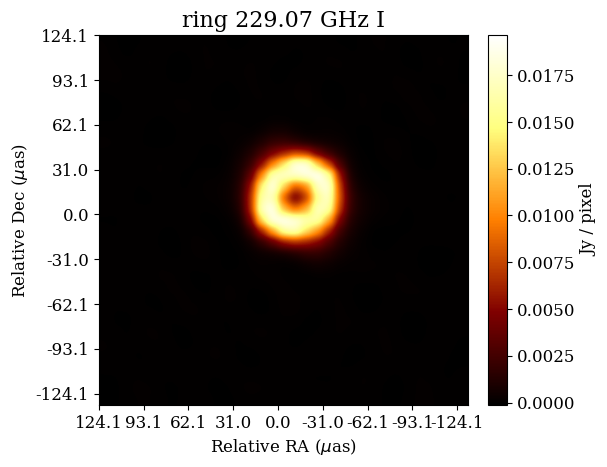

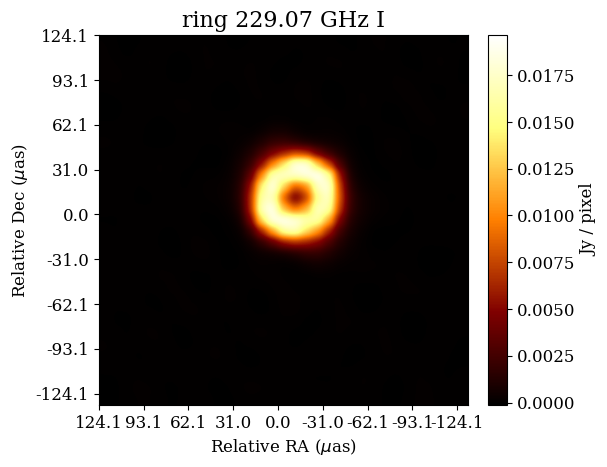

In [11]:
#-------------------------
# Fifth Round of Imaging: visibilities
#-------------------------

print("Round 5: Single Scalar Imaging with visibilities ...")

#project solution to postive values
init = np.maximum(0, img4.imarr()/rescaling)

#run gradient descent minimization
#stepsize automatically found
img = handler.fifth_round(init.copy(), data_term, tau=tau, maxit=1000)

#img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)
img.display()